**TASK 3 : CUSTOMER SEGMENTATION/CLUSTERING**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

customer_transactions = transactions.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    transaction_count=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean'),
    total_quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
    first_transaction_date=pd.NamedAgg(column='TransactionDate', aggfunc='min'),
    last_transaction_date=pd.NamedAgg(column='TransactionDate', aggfunc='max'),
).reset_index()

customer_transactions['recency_days'] = (pd.Timestamp.now() - customer_transactions['last_transaction_date']).dt.days

customer_profile = pd.merge(customers, customer_transactions, on='CustomerID', how='inner')

In [4]:
numeric_features = [
    "total_spent",
    "transaction_count",
    "avg_transaction_value",
    "total_quantity",
    "recency_days",
]
data_for_clustering = customer_profile[numeric_features]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

In [5]:
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

In [6]:
for n_clusters, db_index, silhouette_avg in zip(cluster_range, db_scores, silhouette_scores):
    print(f"Number of Clusters: {n_clusters}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print("-" * 30)

Number of Clusters: 2
Davies-Bouldin Index: 1.1263
Silhouette Score: 0.3246
------------------------------
Number of Clusters: 3
Davies-Bouldin Index: 1.0162
Silhouette Score: 0.3354
------------------------------
Number of Clusters: 4
Davies-Bouldin Index: 1.0801
Silhouette Score: 0.3078
------------------------------
Number of Clusters: 5
Davies-Bouldin Index: 1.0827
Silhouette Score: 0.2826
------------------------------
Number of Clusters: 6
Davies-Bouldin Index: 1.0914
Silhouette Score: 0.2676
------------------------------
Number of Clusters: 7
Davies-Bouldin Index: 1.1279
Silhouette Score: 0.2525
------------------------------
Number of Clusters: 8
Davies-Bouldin Index: 1.1055
Silhouette Score: 0.2566
------------------------------
Number of Clusters: 9
Davies-Bouldin Index: 1.1874
Silhouette Score: 0.2509
------------------------------
Number of Clusters: 10
Davies-Bouldin Index: 1.1301
Silhouette Score: 0.2631
------------------------------


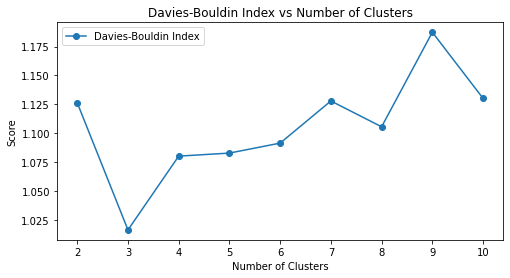

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, db_scores, marker='o', label='Davies-Bouldin Index')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.legend()
plt.show()

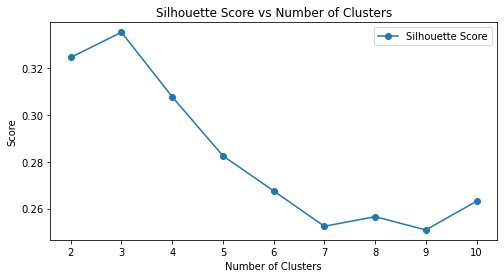

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.legend()
plt.show()

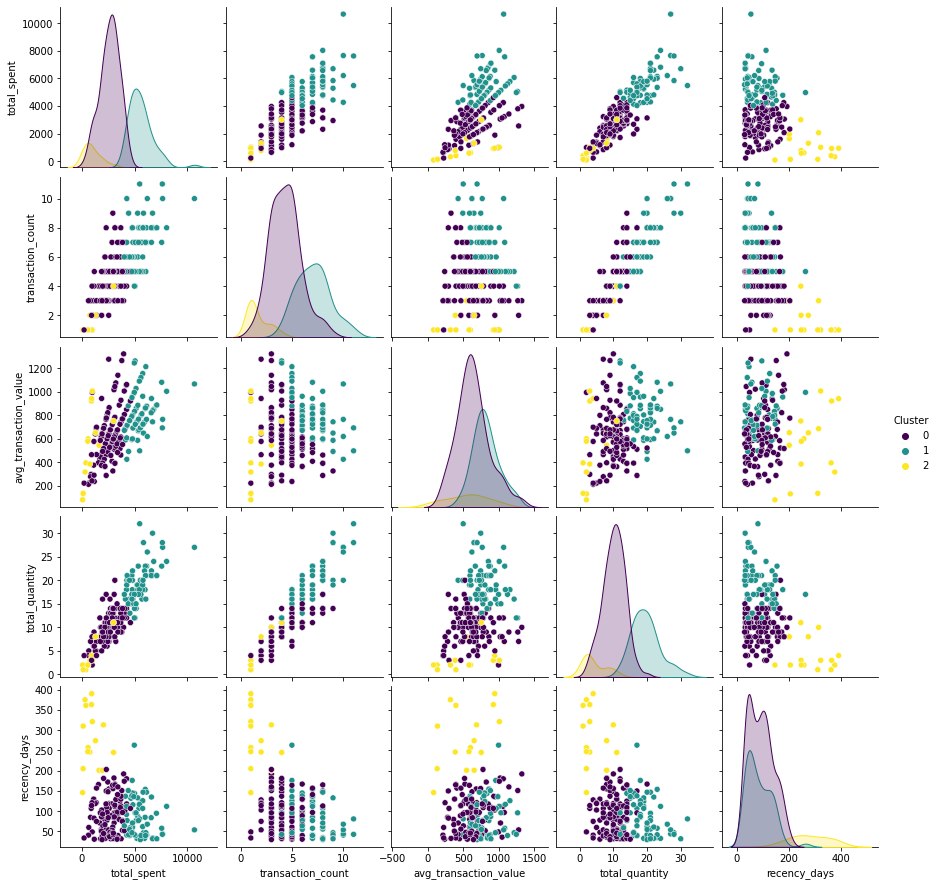

In [10]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)

sns.pairplot(customer_profile, hue='Cluster', vars=numeric_features, palette='viridis')
plt.show()

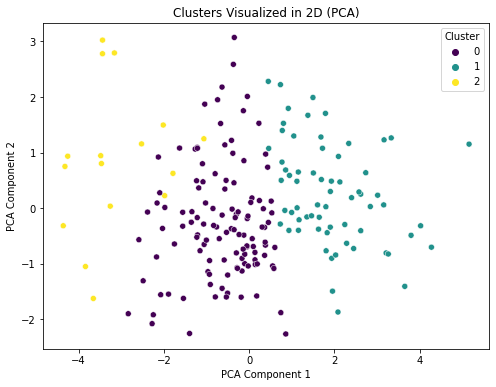

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

customer_profile['PCA1'] = reduced_data[:, 0]
customer_profile['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_profile['PCA1'],
    y=customer_profile['PCA2'],
    hue=customer_profile['Cluster'],
    palette="viridis",
    legend="full"
)
plt.title("Clusters Visualized in 2D (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

<Figure size 720x432 with 0 Axes>

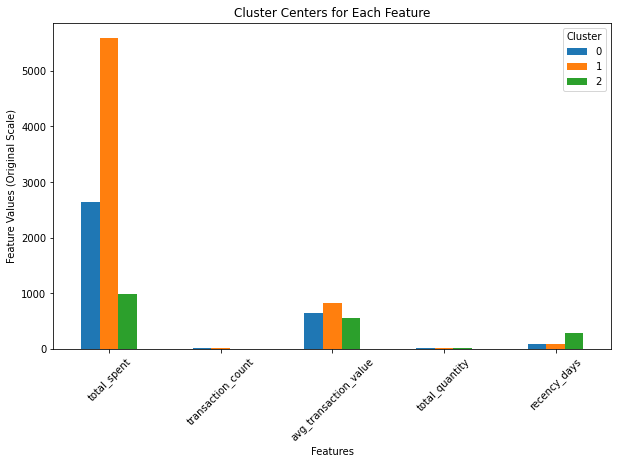

In [14]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numeric_features)

plt.figure(figsize=(10, 6))
cluster_centers_df.T.plot(kind='bar', figsize=(10, 6), legend=True)
plt.title("Cluster Centers for Each Feature")
plt.xticks(range(len(numeric_features)), numeric_features, rotation=45)
plt.ylabel("Feature Values (Original Scale)")
plt.xlabel("Features")
plt.legend(title="Cluster")
plt.show()